# Exploration notebook for steel industry consumption 

**Authors**: 
- Agustín Arturo Melian Su
- Addán Isaí Cruz Cruz

**Date: 11/11/2025**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import  OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
# from statsmodels.tsa.arima.model import ARIMA
import pickle 

In [2]:
df_raw = pd.read_csv('../data/raw/Steel_industry_data.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0    adddate                              35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

In [3]:
df_raw.sample(10, random_state=2025)

,adddate,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
25685,25/09/2018 13:30,2.66,0.00,11.77,0.00,100.00,22.04,48600,Weekday,Tuesday,Light_Load
25306,21/09/2018 14:45,8.60,0.00,15.08,0.00,100.00,49.54,53100,Weekday,Friday,Maximum_Load
16488,21/06/2018 18:15,31.61,12.02,1.84,0.01,93.47,99.83,65700,Weekday,Thursday,Medium_Load
6673,11/03/2018 12:30,24.16,0.00,10.91,0.01,100.00,91.14,45000,Weekend,Sunday,Medium_Load
18748,15/07/2018 07:15,2.74,4.64,0.00,0.00,50.85,100.00,26100,Weekend,Sunday,Light_Load
19130,19/07/2018 06:45,2.59,4.46,0.00,0.00,50.22,100.00,24300,Weekday,Thursday,Light_Load
22081,19/08/2018 00:30,2.59,4.21,0.00,0.00,52.40,100.00,1800,Weekend,Sunday,Light_Load
32434,04/12/2018 20:45,30.67,3.78,2.84,0.01,99.25,99.57,74700,Weekday,Tuesday,Medium_Load
13797,24/05/2018 17:30,73.73,21.64,0.00,0.03,95.95,100.00,63000,Weekday,Thursday,Medium_Load
15816,14/06/2018 18:15,39.06,21.49,1.44,0.02,87.61,99.93,65700,Weekday,Thursday,Medium_Load


In [3]:
df_baking = df_raw.copy()

df_baking.columns = df_baking.columns.str.lower()

columns = [
    'date',
    'usage_kwh',
    'lagging_kvarh',
    'leading_kvarh',
    'co2',
    'lagging_factor',
    'leading_factor',
    'nsm',
    'weekstatus',
    'day_of_week',
    'load_type'
]
df_baking.columns = columns
cat_cols = ['weekstatus']
df_baking[cat_cols] = df_baking[cat_cols].astype('category')
df_baking['date'] = pd.to_datetime(df_baking['date'], format='%d/%m/%Y %H:%M')
df_baking['load_type'] = df_baking['load_type'].replace(
    ['Light_Load', 'Medium_Load', 'Maximum_Load'], [0, 1, 2])
df_baking = df_baking.drop(columns=['nsm', 'day_of_week','co2'])
df_baking = df_baking.set_index('date')
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35040 entries, 2018-01-01 00:15:00 to 2018-12-31 00:00:00
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   usage_kwh       35040 non-null  float64 
 1   lagging_kvarh   35040 non-null  float64 
 2   leading_kvarh   35040 non-null  float64 
 3   lagging_factor  35040 non-null  float64 
 4   leading_factor  35040 non-null  float64 
 5   weekstatus      35040 non-null  category
 6   load_type       35040 non-null  int64   
dtypes: category(1), float64(5), int64(1)
memory usage: 1.9 MB


/tmp/ipykernel_6233/2931059005.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_baking['load_type'] = df_baking['load_type'].replace(


In [ ]:
Save data
df.to_csv('data/processed/steel_processed.csv')

In [7]:
df.index

DatetimeIndex(['2018-01-01 00:15:00', '2018-01-01 00:30:00',
               '2018-01-01 00:45:00', '2018-01-01 01:00:00',
               '2018-01-01 01:15:00', '2018-01-01 01:30:00',
               '2018-01-01 01:45:00', '2018-01-01 02:00:00',
               '2018-01-01 02:15:00', '2018-01-01 02:30:00',
               ...
               '2018-12-31 21:45:00', '2018-12-31 22:00:00',
               '2018-12-31 22:15:00', '2018-12-31 22:30:00',
               '2018-12-31 22:45:00', '2018-12-31 23:00:00',
               '2018-12-31 23:15:00', '2018-12-31 23:30:00',
               '2018-12-31 23:45:00', '2018-12-31 00:00:00'],
              dtype='datetime64[ns]', name='date', length=35040, freq=None)

In [ ]:
df_daily = df.resample().

In [ ]:
# Two weeks for df_test
df_train = df[:33600]
df_test = df[33600:]

df_train.shape, df_test.shape

((33600, 7), (1440, 7))

In [12]:
df.reset_index()['date'].dt.month

0         1
1         1
2         1
3         1
4         1
         ..
35035    12
35036    12
35037    12
35038    12
35039    12
Name: date, Length: 35040, dtype: int32

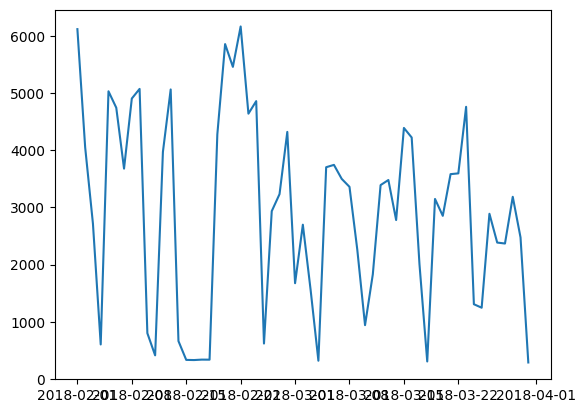

In [17]:
df_daily = df.reset_index()

condition = (df_daily['date'].dt.month > 1) & (df_daily['date'].dt.month < 4)

df_sel = df_daily[condition].set_index('date')

plt.plot(df_sel['usage_kwh'].resample('d').sum())
plt.show()

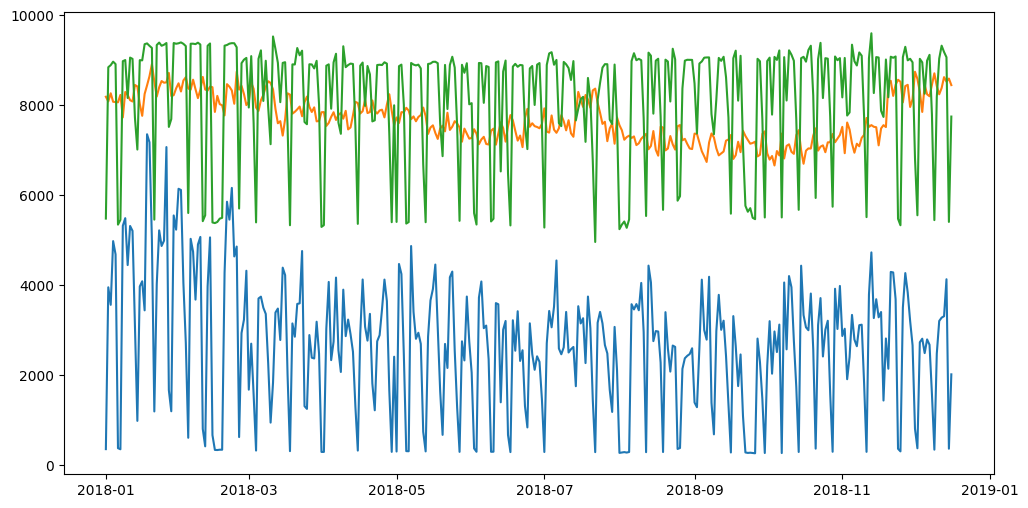

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_train[['usage_kwh']].resample('d').sum())
plt.plot(df_train[['lagging_factor']].resample('d').sum())
plt.plot(df_train[['leading_factor']].resample('d').sum())
plt.show()

In [ ]:
display(df_train.describe(include='number').T)
display(df_train.describe(include='category').T)

,count,mean,std,min,25%,50%,75%,max
usage_kwh,33600.0,27.843553,33.666208,0.0,3.20,4.61,51.74,157.18
lagging_kvarh,33600.0,13.308624,16.417690,0.0,2.63,5.08,23.29,96.91
leading_kvarh,33600.0,3.765144,7.349530,0.0,0.00,0.00,1.66,27.76
lagging_factor,33600.0,80.179209,19.119544,0.0,62.30,87.81,98.69,100.00
leading_factor,33600.0,84.820251,30.120551,0.0,99.83,100.00,100.00,100.00
load_type,33600.0,0.700000,0.793737,0.0,0.00,0.00,1.00,2.00


,count,unique,top,freq
weekstatus,33600,2,Weekday,24000


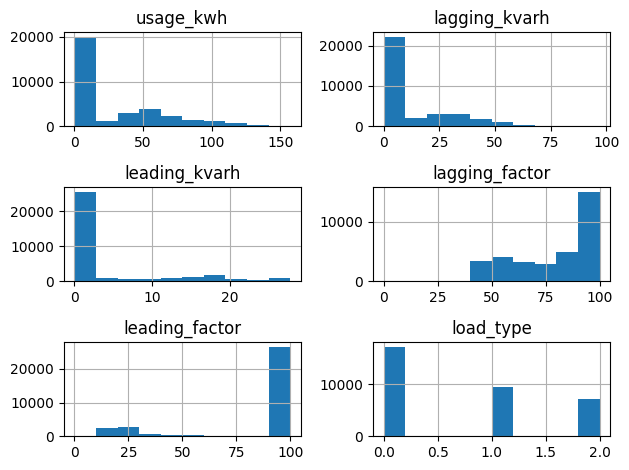

In [ ]:
df_train.hist()
plt.tight_layout()
plt.show()

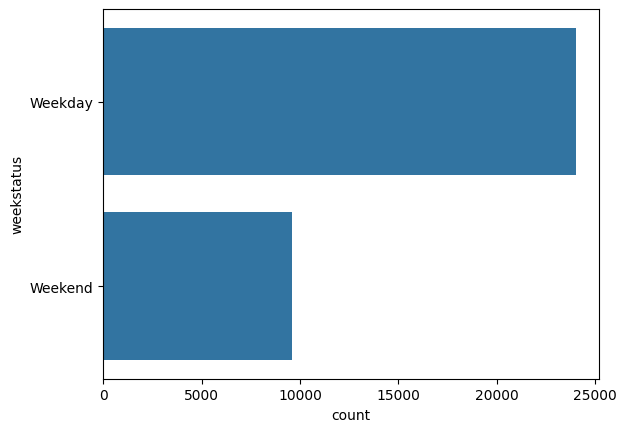

In [ ]:
sns.countplot(df_train, y='weekstatus')
plt.show()

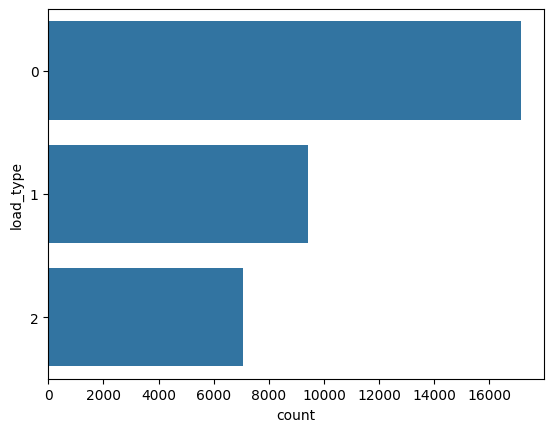

In [ ]:
sns.countplot(df_train, y='load_type')
plt.show()

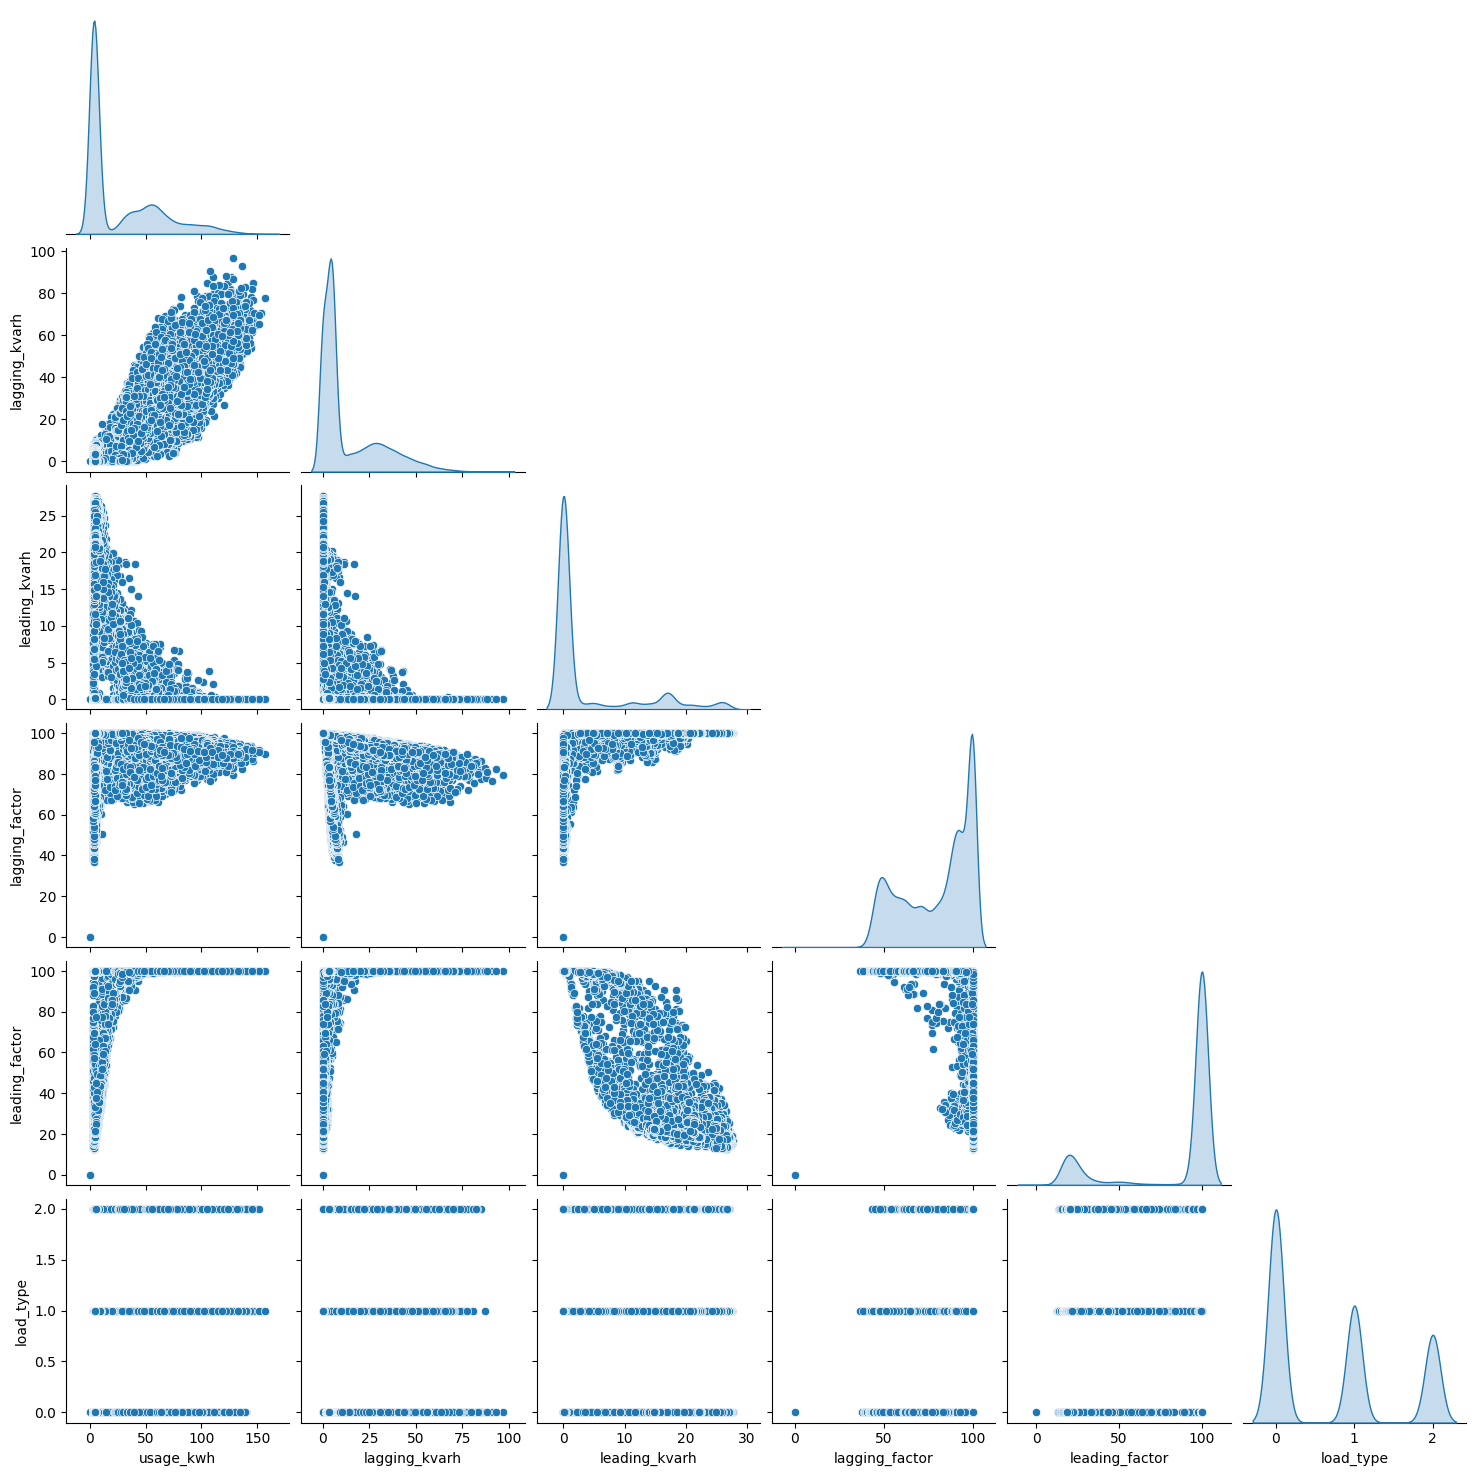

In [ ]:
sns.pairplot(df_train, corner=True, diag_kind='kde')
plt.show()

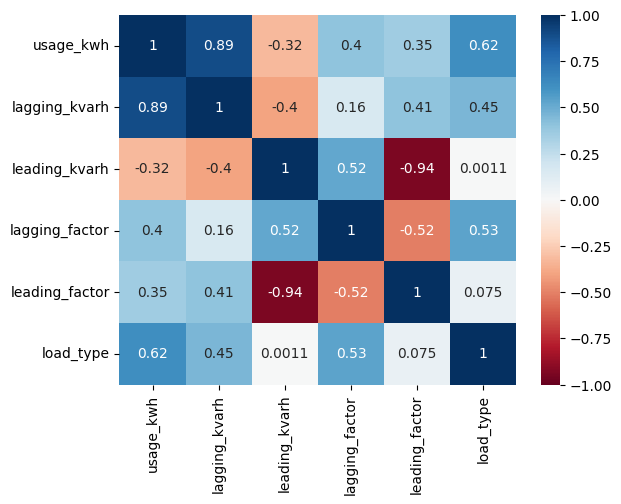

In [ ]:
sns.heatmap(df_train.select_dtypes('number').corr(), vmin=-1, vmax=1, annot=True, cmap='RdBu')
plt.show()

In [ ]:
# ML
X_train = df_train.drop(columns=['usage_kwh'])
X_test = df_test.drop(columns=['usage_kwh'])

y_train = df_train['usage_kwh']
y_test = df_test['usage_kwh']

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

X_train.shape, X_test.shape

((33600, 6), (1440, 6))

In [ ]:
num_cols = X_train.select_dtypes('number').columns
cat_cols = X_train.select_dtypes('category').columns

cat_proc = Pipeline(steps=[
    ('cat_proc', OneHotEncoder())
])

num_proc = Pipeline(steps=[
    ('num_proc', StandardScaler())
])

processor = ColumnTransformer(transformers=[
    ('num', num_proc, num_cols),
    ('cat', cat_proc, cat_cols)
])

In [ ]:
processor.fit_transform(X_test[:2])

array([[ 0.,  0.,  1.,  0.,  0.,  1.],
       [ 0.,  0., -1.,  0.,  0.,  1.]])

In [ ]:
def metrics(y_test, y_hat):
    mse = round(mean_squared_error(y_test, y_hat), 2)
    r2 = round(r2_score(y_test, y_hat), 2)
    mae = round(mean_absolute_error(y_test, y_hat), 2)

    return mse, r2, mae


def display_metrics(metrics_df, name):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))
  fig.suptitle(name, fontsize=16)

  # Plot MSE
  bar1 = axes[0].bar(metrics_df.index, metrics_df['MSE'], color='b')
  axes[0].set_title('Mean Squared Error (MSE)')
  axes[0].set_ylabel('Error')
  axes[0].tick_params(axis='x', rotation=45)

  # Plot R2
  bar2 = axes[1].bar(metrics_df.index, metrics_df['R2'], color='g')
  axes[1].set_title('R2 Score')
  axes[1].set_ylabel('R2')
  axes[1].tick_params(axis='x', rotation=45)

  # Plot MAE
  bar3 = axes[2].bar(metrics_df.index, metrics_df['MAE'], color='r')
  axes[2].set_title('Mean Absolute Error (MAE)')
  axes[2].set_ylabel('Error')
  axes[2].tick_params(axis='x', rotation=45)

  bars = [bar1, bar2, bar3]

  # loop over bars and add annotation
  for i, b in enumerate(bars):
    for bar in b:
      height = bar.get_height()
      axes[i].annotate(
          text = f'{height}',
          xy=(bar.get_x() + bar.get_width() / 2, height + 0.5),
          ha='center',
      )

  plt.tight_layout(rect=[0, 0, 1, 1])
  plt.show()


def plot_time_series(y_test, y_hat, model_name):
  plt.figure(figsize=(14, 6))

  plt.plot(y_test, color='Red', label='Real')
  plt.plot(pd.Series(y_hat, index=y_test.index), color='Green', label='Prediction')

  plt.title(f'Timeseries comparison for {model_name}')
  plt.xlabel('Time')
  plt.ylabel('Usage kwh')

  plt.legend()
  plt.grid(True)

  plt.show()

In [ ]:
lr = Pipeline(steps=[
    ('proc', processor),
    ('lr', LinearRegression())
])

rdg = Pipeline(steps=[
    ('proc', processor),
    ('rdg', Ridge())
])

dt = Pipeline([
    ('proc', processor),
    ('tree', DecisionTreeRegressor(random_state=2025))
])

knn = Pipeline([
    ('proc', processor),
    ('knn', KNeighborsRegressor())
])

rf = Pipeline([
    ('proc', processor),
    ('rf', RandomForestRegressor(random_state=2025))
])

hb = Pipeline([
    ('proc', processor),
    ('hb', HistGradientBoostingRegressor(random_state=2025))
])

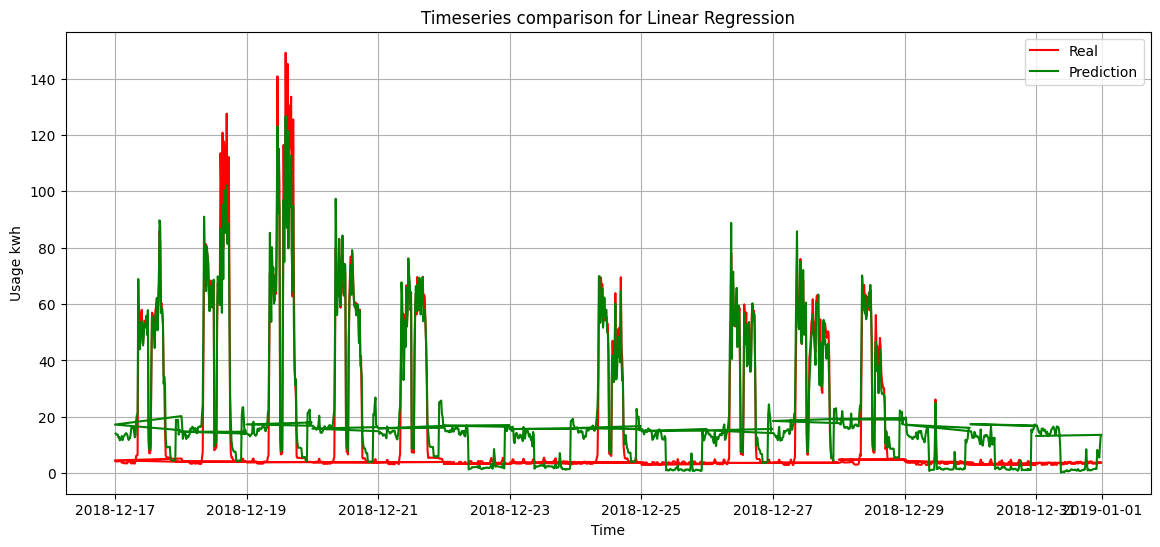

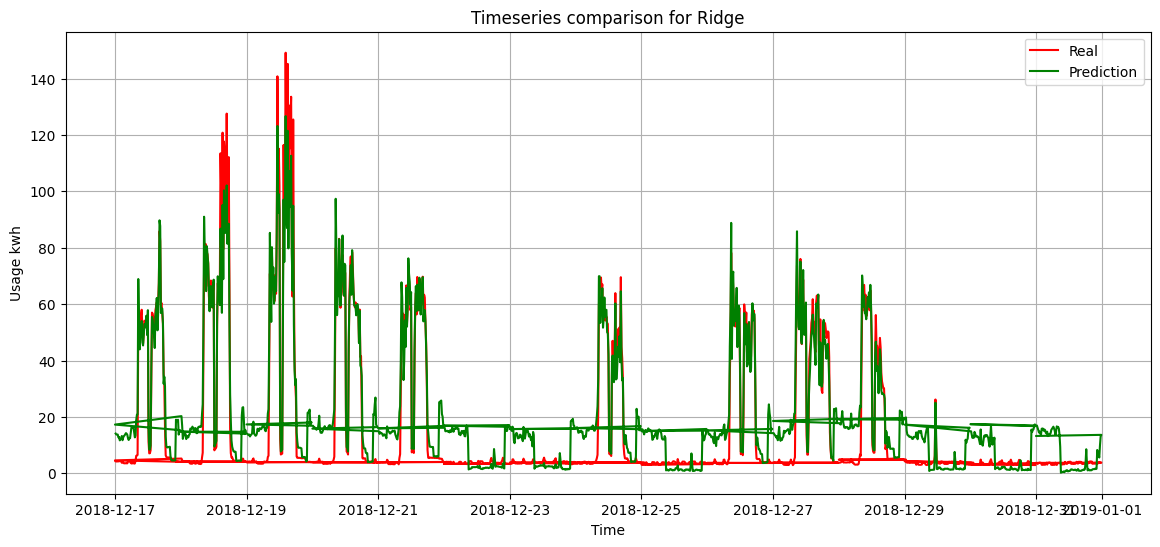

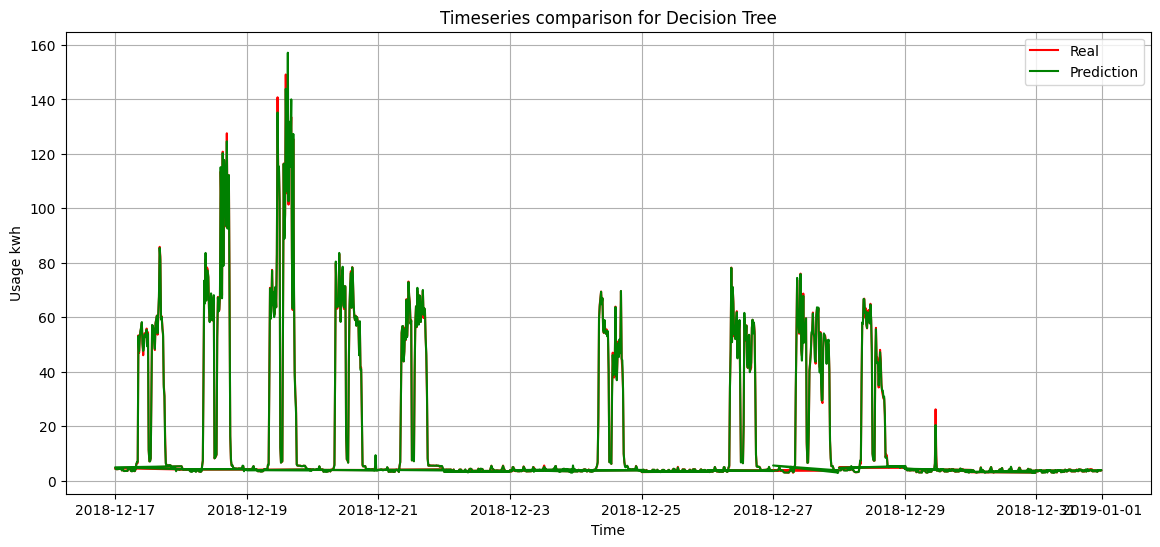

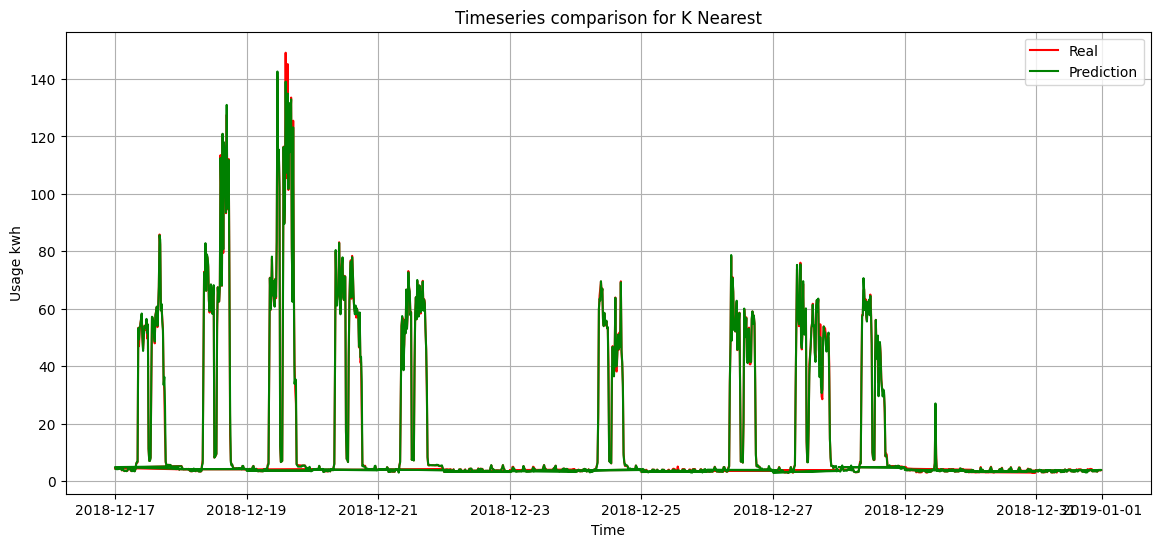

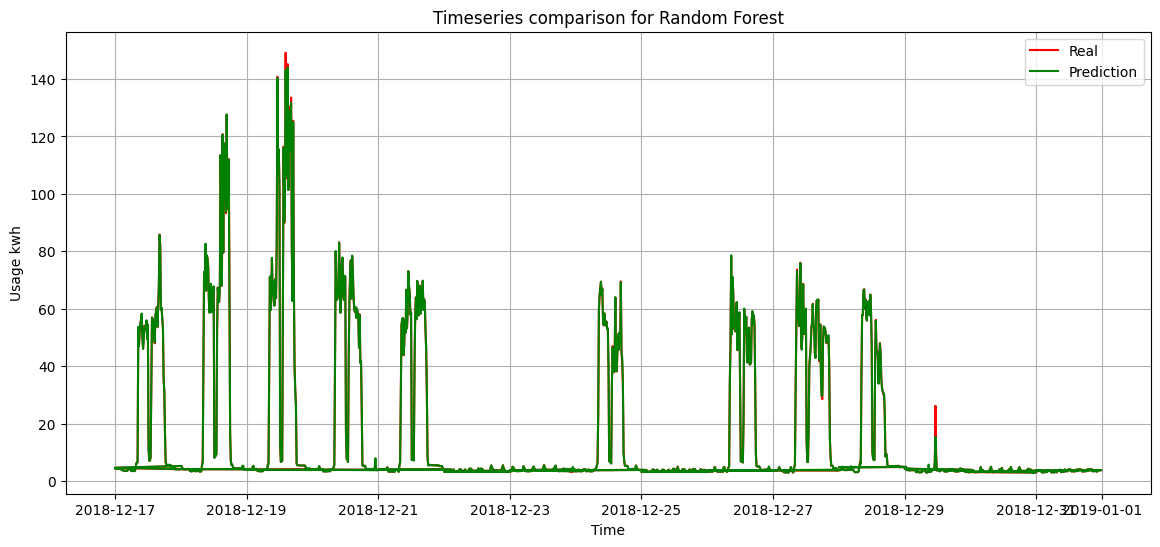

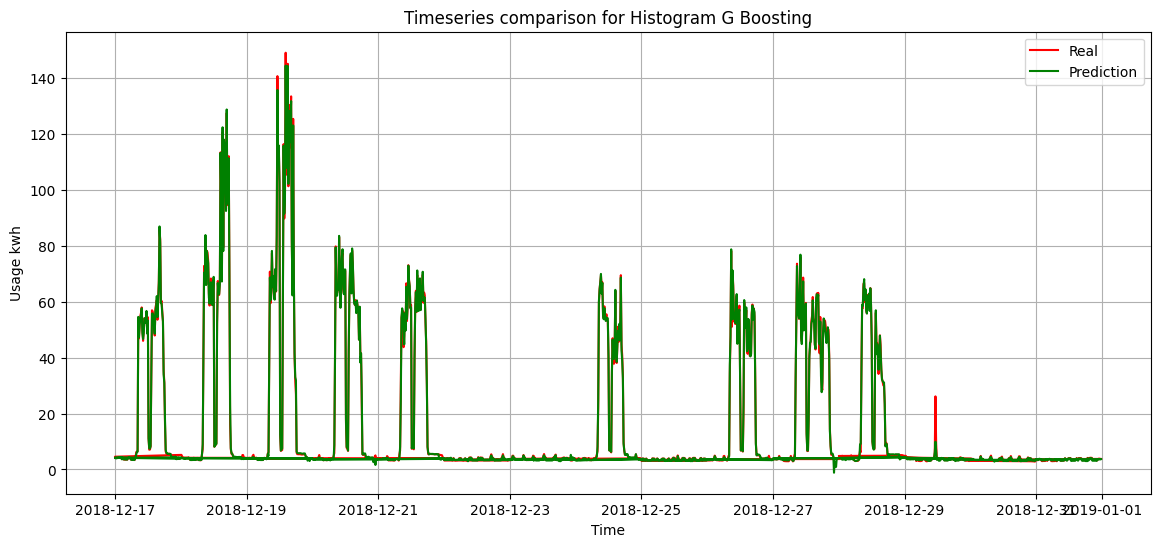

In [ ]:
models = [
    (lr, 'Linear Regression', 'lr'),
    (rdg, 'Ridge', 'rdg'),
    (dt, 'Decision Tree', 'tree'),
    (knn, 'K Nearest', 'knn'),
    (rf, 'Random Forest', 'rf'),
    (hb, 'Histogram G Boosting', 'hb')
]

performance = {}

for est, name, sname in models:
  # Training
  est.fit(X_train, y_train)

  # Prediction
  y_hat = est.predict(X_test)

  mse, r2, mae = metrics(y_test, y_hat)

  performance[name] = {
      'MSE': mse,
      'R2': r2,
      'MAE': mae
  }

  plot_time_series(y_test, y_hat, name)

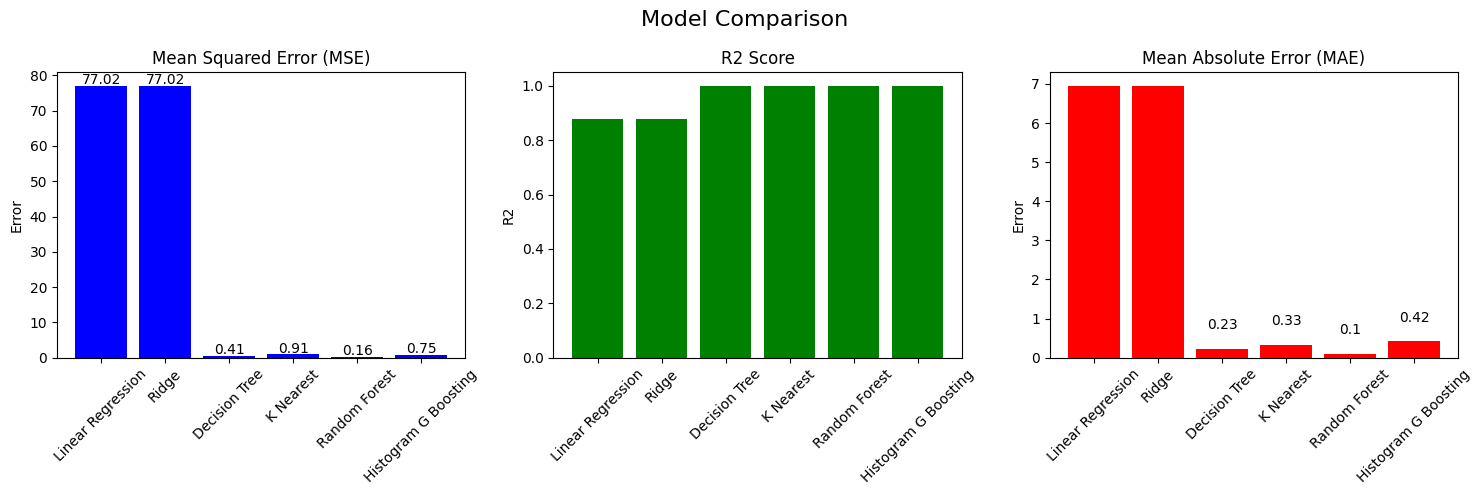

In [ ]:
metrics_df = pd.DataFrame(performance).T

display_metrics(metrics_df, 'Model Comparison')

Elección de modelo:  
Dados los resultados elegimos el modelo que nos entrega los mejores resultado el cual es Random Forest con el menor error y un r2 score alto

In [ ]:
num_cols = X_train.select_dtypes('number').columns
cat_cols = X_train.select_dtypes('category').columns

cat_proc = Pipeline(steps=[
    ('cat_proc', OneHotEncoder())
])

num_proc = Pipeline(steps=[
    ('num_proc', StandardScaler())
])

processor = ColumnTransformer(transformers=[
    ('num', num_proc, num_cols),
    ('cat', cat_proc, cat_cols)
])
rfmodel = Pipeline([
    ('proc', processor),
    ('rf', RandomForestRegressor(random_state=2025))
])
rfmodel.fit(X_train, y_train)

,steps,"[('proc', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
model = {
    'name':'prediction model for steel industry energy consumption',
    'author':'Agustin Melian Su / Addán Isaí Cruz Cruz',
    'model': rf,
    'predictors': X_train.columns.to_list(),
    'target_name': y_train.name,
    'version': '1.0',
    'algorithm_name':'random forest'
}

In [ ]:
df_predict = pd.DataFrame({
    0:[0.00],
    1:[16.99],
    2:[100.00],
    3:[16.94],
    4:['Weekend'],
    5:[0]
    })
df_predict.columns = X_train.columns
model['model'].predict(df_predict)


array([2.9182])

In [ ]:
with open('steel_model.pkl', "wb") as file:
  pickle.dump(model, file)